# **Predicting Dementia Risk Using Brain Health Indicators**

**Author:** Jessica Schmilovich

**Course:** 2025 Summer GSTEM Winston Data Scholarship Data Science Course

**Acknowledgements:** I would like to thank NYU, GSTEM, and the Winston Data Scholarship for the incredible opportunity to complete an additional data science course and project alongside my research internship this summer.

## **Introduction**
This project aims to predict whether individuals have dementia based on various health indicators. Dementia affects millions of people worldwide and is a condition that impacts memory, thinking, and daily functioning. Early detection can be valuable for patients and their families. The main idea behind my model is to identify patterns in health data that correlate with dementia presence, allowing for prediction of dementia status based on a combination of clinical factors. My approach develops a decision tree classifier model that uses cognitive test scores, age, and cardiovascular risk factors to predict dementia status for individuals. The model achieved 70% accuracy on the test set and a True Positive Rate of 78.6%, meaning it correctly identified nearly 8 out of 10 actual dementia cases. When compared to a k-Nearest Neighbors model with k=9, my decision tree model performed better in identifying positive dementia cases despite lower overall accuracy (70% vs 96.4%), as the kNN model achieved a 0% True Positive Rate, failing to identify any actual dementia cases, which demonstrates that high accuracy alone does not guarantee a useful model.

## **1. Data Exploration and Feature Selection**

### **1.1 Loading and Splitting the Data**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load dataset
data = pd.read_csv('TotalBrainHealthDataset.csv', keep_default_na=False)

# manually set only empty strings to NaN
data = data.replace('', np.nan)

# remove both dementia columns from features
# use dementia_all as target since it has values for all patients while dementia has missing values
# both columns contain the same information (yes/no for dementia presence)
X = data.drop(['dementia', 'dementia_all'], axis=1)
Y = data['dementia_all']

# split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 23)

### **1.2 Data Visualizations**

**Visualization 1: Data Exploration and Summary Statistics**

In [2]:
# exploration of training data
print('Training data shape: ' + str(X_train.shape))
print('\n First few observations:')
print(X_train.head())

print('\nData types:')
print(X_train.dtypes)

print('\nSummary Statistics for numerical variables:')
print(X_train.describe())

print('\nMissing values per variable:')
print(X_train.isnull().sum())

Training data shape: (1281, 17)

 First few observations:
      age  gender diabetes hypertension hypercholesterolemia smoking     EF  \
104    68    male       no          Yes                  Yes    Quit  -0.28   
1446   63  female      yes          Yes                  Yes    None    NaN   
901    73  female       no          Yes                  Yes    None  -2.77   
0      54    male       no           No                  Yes    Quit   0.62   
1781   60  female       no           No                   No    Quit  -0.42   

         PS        Global Lacunes_Presence CMB_Presence  Fazekas fazekas_cat  \
104   -1.27  -0.093333333           Absent       Absent        1      0 to 1   
1446    NaN           NaN          Present       Absent        2      2 to 3   
901    -0.7  -1.643333333           Absent       Absent        1      0 to 1   
0      0.22   0.746666667           Absent       Absent        1      0 to 1   
1781   0.38  -0.386666667          Present       Absent        0   

This initial exploration of the training features reveals important characteristics that will guide feature selection for the model. The training set contains 1281 observations with 17 potential predictor variables after removing dementia and dementia_all columns (using dementia_all as our target variable since it has complete data while dementia has missing values). Notable patterns include missing data in the cognitive scores with EF missing 154 values (12%), PS missing 197 values (15%), and Global missing 226 values (18%), while smoking has only 8 missing values (less than 1%). The cardiovascular risk factors (diabetes, hypertension, hypercholesterolemia) and brain imaging markers (Lacunes_Presence, CMB_Presence, Fazekas) have complete data for all observations. The presence of both numerical variables like age and Fazekas scores alongside categorical variables like health conditions and smoking status (which includes Smoker, Quit, and None categories) suggests the need for a model that can handle mixed data types. The complete data availability for cardiovascular risk factors and brain imaging markers make these particular reliable features for model building.

**Visualization 2: Scatter Plot of Cognitive Scores by Dementia Status**

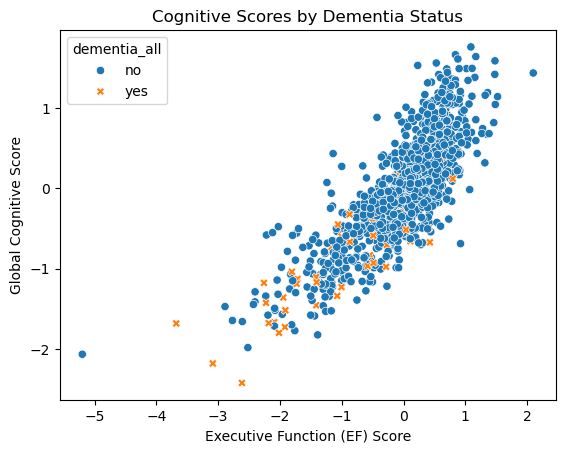

In [3]:
# convert EF and Global columns to numeric type
# this fixes the issue where some values might be stored as strings instead of numbers
# errors='coerce' turns any non-numeric values into NaN
X_train['EF'] = pd.to_numeric(X_train['EF'], errors='coerce')
X_train['Global'] = pd.to_numeric(X_train['Global'], errors='coerce')

# combine training data for plotting
train_data = X_train.copy()
train_data['dementia_all'] = y_train

# remove rows where EF or Global are missing (NaN)
train_data_clean = train_data.dropna(subset=['EF', 'Global'])

# create scatter plot
# EF (executive function) and global are cognitive test scores
sns.scatterplot(data=train_data_clean, x='EF', y='Global', style='dementia_all', hue='dementia_all')
plt.xlabel('Executive Function (EF) Score')
plt.ylabel('Global Cognitive Score')
plt.title('Cognitive Scores by Dementia Status')
plt.show()

This scatter plot shows the relationship between Executive Function (EF) and Global Cognitive scores by dementia status. The plot reveals a clear separation between groups where individuals without dementia (blue) cluster in the upper right with higher scores, while those with dementia (orange) appear in the lower left with lower scores. This visualization indicates that both EF and Global scores are important features to incorporate in the model, as they effectively distinguish between dementia and non-dementia cases. Lower scores on both measures, particularly below 0, are associated with dementia presence, suggesting these cognitive scores should be included as features for predicting dementia status.

**Visualization 3: Box Plot of Age by Dementia Status**

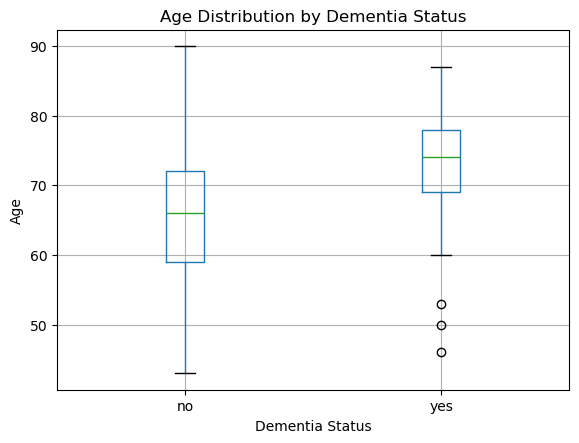

In [4]:
# create box plot
train_data = X_train.copy()
train_data['dementia_all'] = y_train

train_data.boxplot(column='age', by='dementia_all')
plt.title('Age Distribution by Dementia Status')
plt.suptitle('') # removes default title
plt.xlabel('Dementia Status')
plt.ylabel('Age')
plt.show()

This boxplot displays the age distribution for individuals with and without dementia. The median age for those without dementia is approximately 66 years, while the median age for those with dementia is approximately 74 years. The box for dementia cases is positioned higher on the age scale and shows that the majority of dementia cases occur in individuals aged 70 and above. This indicates that age is an important features to incorporate in the model for predicting dementia status, as older age is clearly associated with higher likelihood of having dementia. The distinct difference in age distributions between the two groups suggests that age will be a valuable predictor in distinguishing between dementia and non-dementia cases.

**Visualization 4: Bar Plot of Hypertension by Dementia Status**

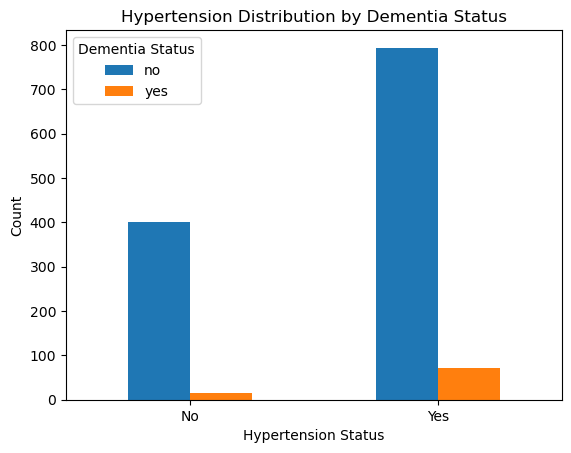

In [5]:
# create grouped bar plot to see relationship
train_data = X_train.copy()
train_data['dementia_all'] = y_train

# count cases
hypertension_dementia = pd.crosstab(train_data['hypertension'], train_data['dementia_all'])
hypertension_dementia.plot(kind='bar')
plt.xlabel('Hypertension Status')
plt.ylabel('Count')
plt.title('Hypertension Distribution by Dementia Status')
plt.xticks(rotation=0)
plt.legend(title='Dementia Status')
plt.show()

This bar plot shows the distribution of hypertension status among individuals with and without dementia. The visualization reveals that the majority of individuals in both groups have hypertension (Yes), but there are notable differences in the proportions. Among those without dementia, approximately 800 have hypertension while 400 do not. For those with dementia, about 65 have hypertension while only about 20 do not have hypertension. This indicates that a higher proportion of dementia patients have hypertension compared to those without dementia. The visualization suggests that hypertension is an important feature to incorporate in the model, as the presence of hypertension appears to be associated with dementia status. The disproportionate prevalence of hypertension among dementia cases compared to non-dementia cases indicates this cardiovascular risk factor could help distinguish between the two groups in the predictive model.

**Visualization 5: Bar Plot of Diabetes by Dementia Status**

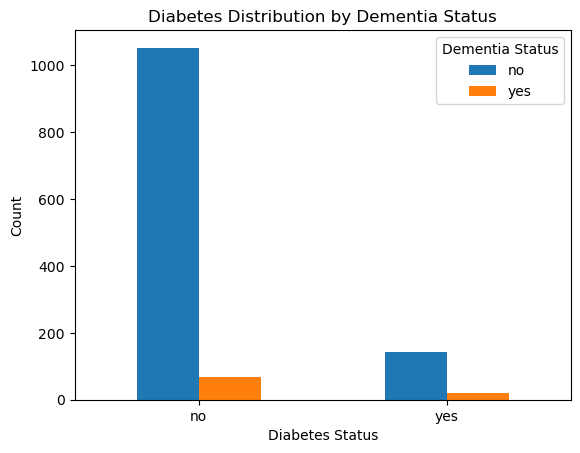

In [6]:
# create grouped bar plot to see relationship
train_data = X_train.copy()
train_data['dementia_all'] = y_train

# count cases
diabetes_dementia = pd.crosstab(train_data['diabetes'], train_data['dementia_all'])
diabetes_dementia.plot(kind='bar')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.title('Diabetes Distribution by Dementia Status')
plt.xticks(rotation=0)
plt.legend(title='Dementia Status')
plt.show()

This bar plot shows the distribution of diabetes status among individuals with and without dementia. The visualization reveals that among those without dementia (blue bars), the vast majority do not have diabetes (approximately 1050) compared to those who have diabetes (approximately 150). Among those with dementia (orange bars), approximately 70 do not have diabetes while only about 15 have diabetes. The proportion of individuals with diabetes is actually higher in the dementia group (approximately 18%) compared to the non-dementia group (approximately 12%). This suggests that diabetes is associated with dementia status and should be included as a feature in the model, as the presence of diabetes could potentially increase the likelihood of having dementia.

## **2. Model Development**

### **2.1 Model Description**

My model is a decision tree classifier that predicts whether an individual has dementia based on multiple health indicators. The model uses a hierarchical decision-making process that first evaluates cognitive scores, then considers age and cardiovascular risk factors. It takes in patient data including age, cognitive test scores (EF and Global), and health conditions (hypertension and diabetes) to output a prediction of either 'yes' (has dementia) or 'no' (does not have dementia).

### **2.2 Rationale for Model Design**

Based on the visualizations, the model's decision logic makes sense for several reasons. The scatter plot showed that while there is some overlap, individuals with both EF and Global scores below -0.5 are much more likely to have dementia, with most dementia cases clustering in this region. This is why the model first checks for this pattern. The box plot revealed that the median age for dementia patients is approximately 74 years compared to 66 years for non-dementia patients, which explains why age thresholds of 65, 70, and 74 are used at different decision points. The model recognizes that older individuals require less severe cognitive decline to predict dementia risk. The hypertension visualization showed that 76% of dementia patients have hypertension versus 67% of non-dementia patients, making it a useful risk factor especially when combined with borderline cognitive scores or older age. Similarly, diabetes is present in 18% of dementia patients versus 12% of non-dementia patients, providing additional predictive value. The model also identifies that individuals with both cognitive scores above 0.5 rarely have dementia, allowing for confident negative predictions in these cases. This hierarchical approach prioritizes the strongest predictors (very low cognitive scores) while using age and cardiovascular risk factors to catch cases that might have more moderate cognitive decline.

### **2.3 Model Implementation**

In [7]:
# decision tree classifier for dementia prediction
# use multiple if-else statements based on patterns observed in data exploration
def predict_dementia(age, ef_score, global_score, hypertension, diabetes):
    
    # both cognitive scores below -0.5 (common dementia pattern)
    if ef_score < -0.5 and global_score < -0.5:
        if age >= 65:
            return 'yes'
        else:
            if hypertension == 'Yes':
                return 'yes'
            else:
                return 'no'
    
    # age 74 (median dementia age) with any negative score
    elif age >= 74:
        if ef_score < 0 or global_score < 0:
            return 'yes'
        elif hypertension == 'Yes':
            return 'yes'
        else:
            return 'no'
    
    # both scores positive (rarely dementia)
    elif ef_score > 0 and global_score > 0:
        return 'no'
    
    # mixed or borderline scores
    else:
        if age >= 70:
            if hypertension == 'Yes' and (ef_score < 0 or global_score < 0):
                return 'yes'
            elif diabetes == 'yes' and (ef_score < 0 or global_score < 0):
                return 'yes'
            else:
                return 'no'
        else:
            return 'no'

## **3. Model Assessment**

### **3.1 Model Evaluation Setup**

In [8]:
# convert EF and Global columns to numeric for test data too
X_test['EF'] = pd.to_numeric(X_test['EF'], errors='coerce')
X_test['Global'] = pd.to_numeric(X_test['Global'], errors='coerce')

# apply model to test data
num_test = len(y_test)
y_predicted = []

for i in range(num_test):
    prediction = predict_dementia(
        X_test.iloc[i]['age'],
        X_test.iloc[i]['EF'],
        X_test.iloc[i]['Global'],
        X_test.iloc[i]['hypertension'],
        X_test.iloc[i]['diabetes'],
    )
    y_predicted.append(prediction)    

### **3.2 Accuracy Metric**

In [9]:
# calculate accuracy as number of correct predictions divided by total predictions
def calculate_accuracy(y_actual, y_predicted):
    correct = 0
    total = len(y_actual)

    for i in range(total):
        if y_actual.iloc[i] == y_predicted[i]:
            correct = correct + 1

    accuracy = correct / total
    return accuracy

# calculate and print accuracy
model_accuracy = calculate_accuracy(y_test, y_predicted)
print('Accuracy: ' + str(model_accuracy))

Accuracy: 0.6994535519125683


### **3.3 Second Performance Metric**

I chose True Positive Rate as my second metric because in medical contexts, it is crucial to correctly identify individuals who actually have dementia. True Positive Rate measures the proportion of actual dementia cases that were correctly identified by the model. Missing a dementia diagnosis (false negative) could delay important treatment and planning, making this metric critical for this model.

In [10]:
# calculate True Positive Rate (proportion of correct predictions out of all actual positive cases)
# True Positive Rate = True Positives / (True Positives + False Negatives)
def calculate_true_positive_rate(y_actual, y_predicted):
    tp = 0 # true positives
    fn = 0 # false negatives

    for i in range(len(y_actual)):
        if y_actual.iloc[i] == 'yes':
            if y_predicted[i] == 'yes':
                tp = tp + 1
            else:
                fn = fn + 1

    # avoid division by 0
    if (tp + fn) == 0:
        return 0

    true_positive_rate = tp / (tp + fn)
    return true_positive_rate

# calculate and print True Positive Rate
model_tpr = calculate_true_positive_rate(y_test, y_predicted)
print('True Positive Rate: ' + str(model_tpr))

True Positive Rate: 0.7857142857142857


### **3.4 Discussion of Results**

The model achieved an accuracy of 70%, meaning it correctly predicted dementia status for 7 out of 10 individuals in the test set. This indicates that the combination of cognitive scores, age, and cardiovascular risk factors provides meaningful predictive power for identifying dementia cases. The True Positive Rate of 78.6% shows that the model successfully identified approximately 79% of actual dementia cases. This is particularly important for a medical screening application where missing dementia cases (false negatives) could result in delayed diagnosis and treatment.

The True Positive Rate being higher than the overall accuracy (78.6% vs 70%) indicates that the model is effective at identifying actual dementia cases. The model's performance demonstrates that the features selected from the data exploration phase, particularly the cognitive scores below 0 and age thresholds around 70-74 years identified in the visualizations, were effective predictors. These two metrics together show that while the model is not perfect, it provides a reasonable balance between overall predictive accuracy and the ability to identify positive cases.

## **4. Model Comparison**

### **4.1 Model Selection and Rationale**

I chose to compare my decision tree model with a k-Nearest Neighbors (kNN) classifier because kNN is a well-established classification algorithm. Unlike my decision tree which uses fixed thresholds, kNN makes predictions based on the similarity to nearby data points, which could potentially capture different parts of the data.

To determine the best value of k, I tested odd values from 3 to 11. I chose odd numbers to avoid ties when voting among neighbors. I selected this range because k=3 might be too sensitive to individual outliers, while k values larger than 11 could include too many neighbors given that there are only 49 dementia cases in the cleaned training data. Testing multiple values allows for finding the optimal balance between underfitting and overfitting. Based on the results, k=9 achieved the highest accuracy of 96.4%, tied with k=11. I selected k=9 as it achieves the same performance with fewer neighbors, making it computationally more efficient and less likely to be influenced by distant points that may not be as relevant to the prediction.

### **4.2 Finding Optimal k Value**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# convert categorical variables to numeric for kNN
# create copies to avoid modifying original data
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()

# convert hypertension: 'Yes' -> 1, 'No' -> 0
X_train_knn['hypertension'] = X_train_knn['hypertension'].map({'Yes': 1, 'No': 0})
X_test_knn['hypertension'] = X_test_knn['hypertension'].map({'Yes': 1, 'No': 0})

# convert diabetes: 'yes' -> 1, 'no' -> 0
X_train_knn['diabetes'] = X_train_knn['diabetes'].map({'yes': 1, 'no': 0})
X_test_knn['diabetes'] = X_test_knn['diabetes'].map({'yes': 1, 'no': 0})

# remove rows with missing values in EF or Global
train_mask = X_train_knn[['EF', 'Global']].notna().all(axis=1)
X_train_knn_clean = X_train_knn[train_mask]
y_train_knn_clean = y_train[train_mask]

test_mask = X_test_knn[['EF', 'Global']].notna().all(axis=1)
X_test_knn_clean = X_test_knn[test_mask]
y_test_knn_clean = y_test[test_mask]

print('Original training data dementia distribution:')
print(y_train.value_counts())
print('\nCleaned kNN training data dementia distribution:')
print(str(y_train_knn_clean.value_counts()))

print('\nOriginal test set size: ' + str(len(y_test)))
print('Cleaned test set size for kNN: ' + str(len(y_test_knn_clean)) + '\n')

# test different k values to find best observations
k_values = [3, 5, 7, 9, 11]
k_accuracies = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_knn_clean[['age', 'EF', 'Global', 'hypertension', 'diabetes']], y_train_knn_clean)
    knn_predictions = knn_model.predict(X_test_knn_clean[['age', 'EF', 'Global', 'hypertension', 'diabetes']])
    accuracy = calculate_accuracy(y_test_knn_clean, knn_predictions)
    k_accuracies.append(accuracy)
    print('k=' + str(k) + ' Accuracy: ' + str(accuracy))

Original training data dementia distribution:
dementia_all
no     1194
yes      87
Name: count, dtype: int64

Cleaned kNN training data dementia distribution:
dementia_all
no     1006
yes      49
Name: count, dtype: int64

Original test set size: 549
Cleaned test set size for kNN: 468

k=3 Accuracy: 0.9551282051282052
k=5 Accuracy: 0.9594017094017094
k=7 Accuracy: 0.9594017094017094
k=9 Accuracy: 0.9636752136752137
k=11 Accuracy: 0.9636752136752137


### **4.3 kNN Implementation and Evaluation**

In [12]:
# use k=9
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_knn_clean[['age', 'EF', 'Global', 'hypertension', 'diabetes']], y_train_knn_clean)

# make predictions
knn_predictions = knn_model.predict(X_test_knn_clean[['age', 'EF', 'Global', 'hypertension', 'diabetes']])

# calculate accuracy
knn_accuracy = calculate_accuracy(y_test_knn_clean, knn_predictions)
print('kNN Accuracy: ' + str(knn_accuracy))

# calculate True Positive Rate
knn_tpr = calculate_true_positive_rate(y_test_knn_clean, knn_predictions)
print('kNN True Positive Rate: ' + str(knn_tpr))

kNN Accuracy: 0.9636752136752137
kNN True Positive Rate: 0.0


### **4.4 Comparison and Discussion**

The kNN model with k=9 achieved an accuracy of 96.4%, which is higher than my decision tree model's 70% accuracy. However, the kNN model achieved a True Positive Rate of 0%, meaning it failed to identify any of the dementia cases in the test set. In contrast, my decision tree model achieved a True Positive Rate of 78.6%, successfully identifying most actual dementia cases.

It is important to note that these kNN results are based on a cleaned subset of the data, as kNN cannot handle missing values or categorical variables directly. After converting the categorical variables to numeric and removing observations with missing cognitive scores, the test set was reduced from 549 to 468 observations. Despite this data preparation giving kNN the best possible chance, it still failed to identify any dementia cases. After observing this True Positive Rate of 0%, I tested all k values below 9 and found they all produced the same 0% True Positive Rate except for k=1, which achieved 17%. However, k=1 is generally not recommended as it is highly sensitive to noise and individual outliers, making predictions unreliable. 

This stark difference reveals the limitation of using accuracy as the sole evaluation metric for imbalanced datasets. The kNN model achieved a high accuracy by simply predicting "no dementia" for all cases, which works well when 96.4% of the test data doesn't have dementia but completely fails at the actual clinical task of identifying dementia patients. With k=9 and only 49 dementia cases in the training data, most neighbors for any test point are non-dementia cases, leading the model to always predict the majority class.

My decision tree model demonstrates superior performance. While it has lower overall accuracy, it successfully balances identifying both dementia and non-dementia cases. The 78.6% True Positive Rate means it would catch approximately 8 out of 10 actual dementia cases, which is crucial for early intervention. The kNN model's 0% True Positive Rate makes it clinically useless despite its high accuracy, as it would miss every single dementia case. This comparison highlights why my decision tree model, with its explicit rules based on cognitive scores, age thresholds, and cardiovascular risk factors, is more suitable for dementia prediction than the distance-based kNN approach on this imbalanced dataset.

## **5. Human Context Discussion**

The use of machine learning to predict dementia from brain health data raises important ethical considerations about medical privacy and the psychological impact of predictive diagnosis. When we analyze cognitive test scores, age, and health conditions to predict whether someone will develop dementia, we must consider how this information truly affects the lives of individuals. The data in this project includes sensitive medical information such as executive function scores, global cognitive assessments, and cardiovascular risk factors, all of which become part of an individual's permanent medical record. This data plays a crucial role because it enables early detection of dementia risk, potentially allowing for interventions that could slow cognitive decline. Healthcare providers can use patterns in the data, such as the correlation between low cognitive scores and dementia presence, to identify at-risk patients years before symptoms become severe. Insurance companies, employers, and even family members might also have interest in this predictive information, which raises questions about who should have access to these predictions.

A significant controversy exists around whether individuals should be informed about their predicted dementia risk when there is no cure for the condition. Those who support early prediction argue that people have a right to know their health risks and that this knowledge has the ability to empower them to make informed decisions about their future. They can pursue clinical trials, make financial arrangements, create advanced directives, and spend quality time with family while still cognitively capable. Early prediction might also motivate lifestyle changes like increased exercise, better diet, and social engagement that could potentially slow cognitive decline. On the other side, critics argue that predicting dementia can cause severe psychological distress without providing clear benefits. People predicted to develop dementia may face discrimination in employment or insurance, experience depression and anxiety, or have their relationships affected by others viewing them as "pre-demented." There are also concerns about false positives, where healthy individuals are incorrectly predicted to develop dementia and suffer unnecessary stress and life disruption.

I believe machine learning models do help healthcare entities make better decisions about dementia risk, but only when used appropriately as screening tools rather than definitive diagnoses. These models can process multiple variables simultaneously and identify patterns that human clinicians might miss, such as subtle combinations of cognitive scores and health conditions that indicate increased risk. This capability allows healthcare systems to allocate resources more efficiently, ensuring high-risk individuals receive additional monitoring and support. However, the models should supplement, rather than replace, clinical judgement. A model with 70% accuracy still misclassifies 30% of cases, which could mean either false reassurance or unnecessary alarm for many individuals. The key is transparency about the model's limitations and ensuring predictions are communicated carefully with appropriate counseling. Healthcare providers must also address bias in training data, as models developed on specific populations may not generalize well to diverse groups, potentially exacerbating healthcare disparities. When implemented thoughtfully, with clear protocols about data use and patient consent, machine learning can enhance dementia care by enabling earlier intervention while respecting patient autonomy and dignity.

## **References**

Sanaei, M. TotalBrainHealthDataset. Kaggle. Retrieved August 2025 from https://www.kaggle.com/datasets/snmahsa/comprehensive-health-and-brain-imaging-dataset